# Predict poverty from space

L'objectif de ce notebook est d'extraire et de mettre en forme les différents formats de données à notre disposition.

Nous avons notamment les sondages, contenant l'indice de richesse de plusieurs régions dans divers pays d'Afrique ainsi que les coordonnées géographiques de ces régions. Ensuite, nous possèdons une carte donnant l'intensité lumineuse de nuit de l'ensemble de la surface terrestre, à une précision de 30 secondes d'arc (~1km au niveau de l'équateur). Enfin, nous pouvons extraire les images satellites de jour des régions concernées en utilisant les coordonnées géographiques et l'API de Google Maps.

Voici l'organisation des fichiers :

* LICENSE  
* README.md
* Gaussian_Process.ipynb
* 0_data.ipynb
* data/ 
    *    daytime_images/  
    *    nightlights_intensities/  
        * F182010.v4d_web.stable_lights.avg_vis.tif  
    *    surveys/
        * DHS/
            * Rwanda_2010/
                * RWGE61FL.dbf
                * RWHR61FL.DTA
            * ...
        * LSMS-ISA/
            * ...
* models/
* papers/

## 0) Importations

In [1]:
import pandas as pd
import numpy as np
from simpledbf import Dbf5
from osgeo import gdal, ogr, osr
import seaborn as sns

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


## 1) Import wealth data and geographical data

L'objectif de cette section est d'importer deux dataset : le premier correspond au résultat des sondages, avec notamment l'indice de richesse, le second correspond aux coordonnées géographiques relatives à ces sondages.

In [2]:
wealth_file = "./data/surveys/DHS/Rwanda_2010/RWHR61FL.DTA"
geo_file = "./data/surveys/DHS/Rwanda_2010/RWGE61FL.dbf"

In [2]:
wealth_file = "./data/surveys/DHS/Uganda_2011/UGHR60FL.DTA"
geo_file = "./data/surveys/DHS/Uganda_2011/UGGE61FL.dbf"

Le premier fichier (RWHR61FL.DTA) contient les résultats des sondages. Deux colonnes nous intéressent plus particulièrement : HV001 est un identifiant qui fait le lien avec les données géographiques et HV271 contient un indice de richesse de la région.

In [3]:
df_wealth = pd.read_stata(wealth_file)

In [4]:
result_wealth = df_wealth.groupby('hv001')['hv271'].median().reset_index()
result_wealth['hv271'] /= 100000.
result_wealth.head()

,hv001,hv271
0,1,1.387615
1,2,1.116070
2,4,1.223320
3,6,2.846490
4,8,1.238415


Le second fichier contient les coordonnées géographiques des sondages. Nous nous intéressons notamment à la colonne DHSCLUST qui fait le lien avec les clusters du fichier précédent ainsi qu'aux colonnes LATNUM et LONGNUM qui nous permettront d'obtenir l'intensité lumineuse de ces zones géographiques ainsi que les images satellites de jour.

In [5]:
dbf = Dbf5(geo_file)
df_geo = dbf.to_dataframe()

In [6]:
result_geo = df_geo[['DHSCLUST', 'LATNUM', 'LONGNUM']]
result_geo['DHSCLUST'] = result_geo['DHSCLUST'].astype(int)
result_geo.head()

/home/ridouane/anaconda3/envs/Predict-poverty/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,DHSCLUST,LATNUM,LONGNUM
0,1,0.324718,32.578131
1,2,0.355171,32.598544
2,4,0.303904,32.566707
3,6,0.323517,32.575550
4,8,0.365799,32.569438


## 2) Merge wealth and geographical data

L'objectif de cette section est d'obtenir un tableau de données dans lequel on a l'indice de richesse en fonction des coordonnées géographiques.

In [7]:
wealth_geo_merge = pd.merge(result_wealth, result_geo, how='inner', left_on='hv001', right_on='DHSCLUST')[['DHSCLUST', 'LATNUM', 'LONGNUM', 'hv271']]
wealth_geo_merge = wealth_geo_merge.rename(columns={'DHSCLUST': 'cluster', 'LATNUM': 'latitude', 'LONGNUM': 'longitude', 'hv271': 'wealth_index'})
wealth_geo_merge.head()

,cluster,latitude,longitude,wealth_index
0,1,0.324718,32.578131,1.387615
1,2,0.355171,32.598544,1.116070
2,4,0.303904,32.566707,1.223320
3,6,0.323517,32.575550,2.846490
4,8,0.365799,32.569438,1.238415


In [8]:
n_clust = wealth_geo_merge['cluster'].max()
print(n_clust)

712


In [12]:
to_drop = []
for index, row in wealth_geo_merge.iterrows() :
    sample = row['longitude'], row['latitude']
    if sample == (0., 0.):
        to_drop.append(index)
wealth_geo_merge = wealth_geo_merge.drop(to_drop)

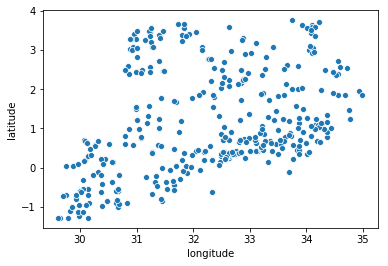

In [13]:
sns.scatterplot(x='longitude', y='latitude', data=wealth_geo_merge)

## 3) Import nightlights intensities data

L'objectif de cette section est d'importer le dataset contenant les intensités lumineuses sur l'ensemble de la surface terrestre.

In [14]:
night_file = './data/nightlights_intensities/F182010.v4d_web.stable_lights.avg_vis.tif'

In [15]:
dataset = gdal.Open(night_file, gdal.GA_ReadOnly)

In [16]:
print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
                             dataset.GetDriver().LongName))
print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
print("Projection is {}".format(dataset.GetProjection()))
(upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = dataset.GetGeoTransform()
print("Origin = ({}, {})".format(upper_left_x, upper_left_y))
print("Pixel Size = ({}, {})".format(x_size, y_size))

Driver: GTiff/GeoTIFF
Size is 43201 x 16801 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
Origin = (-180.00416666665, 75.00416666665)
Pixel Size = (0.0083333333, -0.0083333333)


In [17]:
band = dataset.GetRasterBand(1)
print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))
      
min = band.GetMinimum()
max = band.GetMaximum()
if not min or not max:
    (min,max) = band.ComputeRasterMinMax(True)
print("Min={:.3f}, Max={:.3f}".format(min,max))

Band Type=Byte
Min=0.000, Max=63.000


In [18]:
band_array = band.ReadAsArray()
rows, cols = np.shape(band_array)

In [19]:
x_size = 1.0 / int(round(1 / float(x_size)))
y_size = - x_size
y_index = np.arange(band_array.shape[0])
x_index = np.arange(band_array.shape[1])
top_left_x_coords = upper_left_x + x_index * x_size
top_left_y_coords = upper_left_y + y_index * y_size
centroid_x_coords = top_left_x_coords + (x_size / 2)
centroid_y_coords = top_left_y_coords + (y_size / 2)

In [20]:
def get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    lon_idx = np.where(top_left_x_coords < lon)[0][-1]
    lat_idx = np.where(top_left_y_coords > lat)[0][-1]
    return lon_idx, lat_idx

def get_nightlight_feature(sample):
    x, y = sample
    lon_idx, lat_idx = get_cell_idx(x, y, top_left_x_coords, top_left_y_coords)
    
    # Select the 10 * 10 pixels
    left_idx = lon_idx - 5
    right_idx = lon_idx + 4
    up_idx = lat_idx - 5
    low_idx = lat_idx + 4
    luminosity_100 = []
    
    for i in range(left_idx, right_idx + 1):
        for j in range(up_idx, low_idx + 1):
            # Get the luminosity of this pixel
            luminosity = band_array[j, i]
            luminosity_100.append(luminosity)
    
    luminosity_100 = np.asarray(luminosity_100)
    
    max_ = np.max(luminosity_100)
    min_ = np.min(luminosity_100)
    mean_ = np.mean(luminosity_100)
    median_ = np.median(luminosity_100)
    std_ = np.std(luminosity_100)
    
    return max_, min_, mean_, median_, std_

On a maintenant une fonction qui prend en entrée les coordonnées géographiques de la région qui nous intéresse et donne en sortie l'intensité lumineuse de la zone de 10kms x 10kms autour de ce point. La fonction renvoie l'intensité lumineuse sous la forme : maximum, minimum, moyenne, médiane, écart-type.

In [21]:
n = 20
sample = wealth_geo_merge['longitude'][n], wealth_geo_merge['latitude'][n]
print(sample)
print(wealth_geo_merge['wealth_index'][n])
print(get_nightlight_feature((sample)))

(32.63996, 0.290288)
1.93173
(63, 7, 35.74, 37.0, 19.759362337889346)


## 4) Merge wealth, geographical and nightlights intensities data

L'objectif de cette partie est d'obtenir un tableau de données dans lequel on a, pour chaque région : ses coordonnées, l'indice de richesse associé et les indices de luminosité.

In [22]:
result_light = np.zeros([n_clust, 6])
for index, row in wealth_geo_merge.iterrows() :
    sample = row['longitude'], row['latitude']
    max_, min_, mean_, median_, std_ = get_nightlight_feature(sample)
    result_light[index] = [index+1, max_, min_, mean_, median_, std_]

In [23]:
result_light = pd.DataFrame({'index': result_light[:,0],
                             'max_light': result_light[:,1], 
                             'min_light': result_light[:,2],
                             'mean_light': result_light[:,3],
                             'median_light': result_light[:,4],
                             'std_light': result_light[:,5]})
result_light['index'] = result_light['index'].astype(int)

In [24]:
wealth_geo_light_merge = pd.merge(wealth_geo_merge, result_light, how='inner', left_on='cluster', right_on='index')[['cluster', 'latitude', 'longitude', 'wealth_index', 'mean_light', 'median_light', 'std_light', 'min_light', 'max_light']]
wealth_geo_light_merge.head()

,cluster,latitude,longitude,wealth_index,mean_light,median_light,std_light,min_light,max_light
0,1,0.324718,32.578131,1.387615,61.19,62.0,2.047901,52.0,63.0
1,2,0.355171,32.598544,1.116070,52.86,58.0,11.606050,25.0,63.0
2,4,0.303904,32.566707,1.223320,61.19,62.0,2.047901,52.0,63.0
3,6,0.323517,32.575550,2.846490,48.74,53.5,13.368336,20.0,63.0
4,8,0.365799,32.569438,1.238415,38.90,38.0,16.455698,13.0,62.0


In [25]:
wealth_geo_light_merge.to_csv('./data/uganda')

In [26]:
df_malawi = pd.read_csv('./data/uganda')
df_malawi.head()

,Unnamed: 0,cluster,latitude,longitude,wealth_index,mean_light,median_light,std_light,min_light,max_light
0,0,1,0.324718,32.578131,1.387615,61.19,62.0,2.047901,52.0,63.0
1,1,2,0.355171,32.598544,1.116070,52.86,58.0,11.606050,25.0,63.0
2,2,4,0.303904,32.566707,1.223320,61.19,62.0,2.047901,52.0,63.0
3,3,6,0.323517,32.575550,2.846490,48.74,53.5,13.368336,20.0,63.0
4,4,8,0.365799,32.569438,1.238415,38.90,38.0,16.455698,13.0,62.0


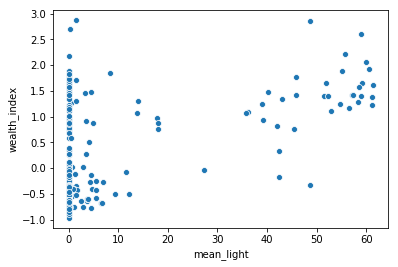

In [27]:
sns.scatterplot(x='mean_light', y='wealth_index', data=df_malawi)

## 8) Try to predict wealth thanks to deep features from daytime images (NOT HERE)

## 11) Retrain CNN by predicting nightlights intensities thanks to daytime images

## 12) Try to predict wealth thanks to new deep features from daytime images

## 13) Implement gaussian processes combined with neural networks

## 14) Try to predict wealth thanks to deep kernel learning

## 15) Display result on a real map of African countries